In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier

warnings.filterwarnings('ignore')
sns.set_style("darkgrid")

# 0. Data Preprocessing

In [ ]:
fish = pd.read_csv("https://bit.ly/fish_csv_data")
fish.head()

,Species,Weight,Length,Diagonal,Height,Width
0,Bream,242.0,25.4,30.0,11.5200,4.0200
1,Bream,290.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,26.5,31.1,12.3778,4.6961
3,Bream,363.0,29.0,33.5,12.7300,4.4555
4,Bream,430.0,29.0,34.0,12.4440,5.1340


In [ ]:
X,y = fish.iloc[:,1:], fish['Species']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

sc = StandardScaler()
sc.fit(X_train)
X_train_scaled = sc.transform(X_train)
X_test_scaled = sc.transform(X_test)

X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

# 1. sklearn.SGDClassifier

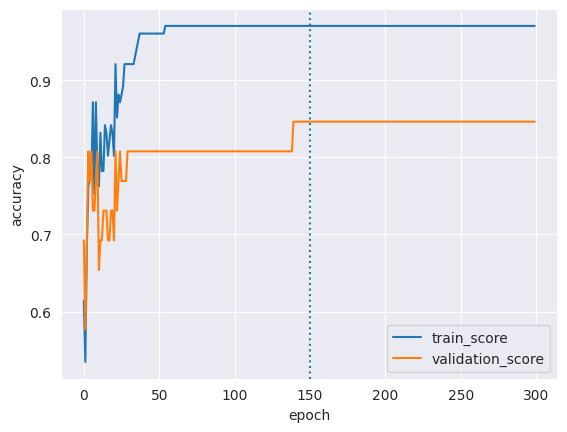

In [ ]:
clf = SGDClassifier(loss='log', random_state=42)
train_score, val_score = [], []
classes = np.unique(y)

for _ in range(0,300):
    clf.partial_fit(X_train_scaled, y_train, classes=classes)
    train_score.append(clf.score(X_train_scaled, y_train))
    val_score.append(clf.score(X_val_scaled, y_val))

plt.plot(train_score, label='train_score')
plt.plot(val_score, label='validation_score')
plt.axvline(x=150,linestyle='dotted')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [ ]:
clf_fin = SGDClassifier(loss='log', max_iter=150,random_state=42)
clf_fin.fit(X_train_scaled, y_train)
print(clf_fin.score(X_train_scaled, y_train))
print(clf_fin.score(X_test_scaled, y_test))

0.8415841584158416
0.90625


# 2. my code

In [ ]:
class optim(object):
    def __init__(self):
        pass

    def sgd(w, grads, config=None):
        if config is None:
            config = {}

        config.setdefault("learning_rate", 1e-2)
        w -= config['learning_rate']*grads
        return w, config

    def sgd_momentum(w, dw, config=None):
        if config is None:
            config = {}
        config.setdefault("learning_rate", 1e-2)
        config.setdefault("momentum", 0.9)
        v = config.get("velocity", np.zeros_like(w))

        v = config['momentum'] * v - config['learning_rate'] * dw
        next_w = w + v

        config["velocity"] = v

        return next_w, config

    def rmsprop(w, dw, config=None):
        if config is None:
            config = {}

        config.setdefault("learning_rate", 1e-2)
        config.setdefault("decay_rate", 0.99)
        config.setdefault("epsilon", 1e-8)
        config.setdefault("cache", np.zeros_like(w))

        cache = config['decay_rate'] *config['cache'] + (1-config['decay_rate']) * dw**2
        next_w = w - config['learning_rate'] * dw / (np.sqrt(cache) + config['epsilon'])
        config['cache'] = cache

        return next_w, config

    def adam(w, dw, config=None):
        if config is None:
            config = {}

        config.setdefault("learning_rate", 1e-3)
        config.setdefault("beta1", 0.9)
        config.setdefault("beta2", 0.999)
        config.setdefault("epsilon", 1e-8)
        config.setdefault("m", np.zeros_like(w))
        config.setdefault("v", np.zeros_like(w))
        config.setdefault("t", 0)

        t = config['t'] + 1
        m = config['beta1']*config['m'] + (1-config['beta1'])*dw
        v = config['beta2']*config['v'] + (1-config['beta2'])*(dw**2)

        mt = m / (1 - config['beta1']**t)
        vt = v / (1 - config['beta2']**t)
        next_w = w - config['learning_rate'] * mt / (np.sqrt(vt) + config['epsilon'])
        config['m'] = m
        config['v'] = v
        config['t'] = t

        return next_w, config

In [ ]:
class SGD_Solver(object):
    def __init__(self, model,X_train,X_val,y_train,y_val, **kwargs):
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val

        # Unpack keyword arguments
        self.update_rule = kwargs.pop("update_rule", "sgd")
        self.update_rule = getattr(optim, self.update_rule)

        self.optim_config = kwargs.pop("optim_config", {})
        self.lr_decay = kwargs.pop("lr_decay", 1.0)
        self.batch_size = kwargs.pop("batch_size", 100)
        self.num_epochs = kwargs.pop("num_epochs", 10)
        self.num_train_samples = kwargs.pop("num_train_samples", 1000)
        self.num_val_samples = kwargs.pop("num_val_samples", None)

        self._reset()

    def _reset(self):
        # Set up some variables for book-keeping
        self.epoch = 0
        self.best_val_acc = 0
        self.best_params = {}
        self.loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []

        # Make a deep copy of the optim_config for each parameter
        self.optim_configs = {}
        for p in self.model.params:
            d = {k: v for k, v in self.optim_config.items()}
            self.optim_configs[p] = d

    def _step(self):
        # Make a minibatch of training data
        num_train = self.X_train.shape[0]
        batch_mask = np.random.choice(num_train, self.batch_size)
        X_batch = self.X_train[batch_mask]
        y_batch = self.y_train[batch_mask]

        # Compute loss and gradient
        loss, grads = self.model.loss(X_batch, y_batch)
        self.loss_history.append(loss)

        # Perform a parameter update
        for p, w in self.model.params.items():
            dw = grads[p]
            config = self.optim_configs[p]
            next_w, next_config = self.update_rule(w, dw, config)
            self.model.params[p] = next_w
            self.optim_configs[p] = next_config

    def check_accuracy(self, X, y, num_samples=None, batch_size=100):
        """
        Check accuracy of the model on the provided data.

        Inputs:
        - X: Array of data, of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,)
        - num_samples: If not None, subsample the data and only test the model
          on num_samples datapoints.
        - batch_size: Split X and y into batches of this size to avoid using
          too much memory.

        Returns:
        - acc: Scalar giving the fraction of instances that were correctly
          classified by the model.
        """

        # Maybe subsample the data
        N = X.shape[0]
        if num_samples is not None and N > num_samples:
            mask = np.random.choice(N, num_samples)
            N = num_samples
            X = X[mask]
            y = y[mask]

        # Compute predictions in batches
        num_batches = N // batch_size
        if N % batch_size != 0:
            num_batches += 1
        y_pred = []
        for i in range(num_batches):
            start = i * batch_size
            end = (i + 1) * batch_size
            scores = self.model.loss(X[start:end])
            y_pred.append(np.argmax(scores, axis=1))
        y_pred = np.hstack(y_pred)
        acc = np.mean(y_pred == y)

        return acc

    def train(self):
        num_train = self.X_train.shape[0]
        iterations_per_epoch = max(num_train // self.batch_size, 1)
        num_iterations = self.num_epochs * iterations_per_epoch

        for t in range(num_iterations):
            self._step()

            # At the end of every epoch, increment the epoch counter and decay
            # the learning rate.
            epoch_end = (t + 1) % iterations_per_epoch == 0
            if epoch_end:
                self.epoch += 1
                for k in self.optim_configs:
                    self.optim_configs[k]["learning_rate"] *= self.lr_decay

            # Check train and val accuracy on the first iteration, the last
            # iteration, and at the end of each epoch.
            first_it = t == 0
            last_it = t == num_iterations - 1
            if first_it or last_it or epoch_end:
                train_acc = self.check_accuracy(
                    self.X_train, self.y_train, num_samples=self.num_train_samples
                )
                val_acc = self.check_accuracy(
                    self.X_val, self.y_val, num_samples=self.num_val_samples
                )
                self.train_acc_history.append(train_acc)
                self.val_acc_history.append(val_acc)

                # Keep track of the best model
                if val_acc > self.best_val_acc:
                    self.best_val_acc = val_acc
                    self.best_params = {}
                    for k, v in self.model.params.items():
                        self.best_params[k] = v.copy()

        # At the end of training swap the best params into the model
        self.model.params = self.best_params

In [ ]:
class LinearClassifier(object):
    def __init__(self, input_dim=5, num_classes= 7, weight_scale=1e-3, reg=0.0, no_loop=True):
        self.params = {'W' : np.random.randn(input_dim, num_classes) * weight_scale}
        self.reg = reg
        self.no_loop = no_loop

    def get_loss(self):
        return self.loss_hist


    def loss(self, X_batch, y_batch, reg):
        """
        Subclasses will override this.
        """
        pass

    def predict(self, X):
        y_pred = np.zeros(X.shape[0]) # num_trains
        W = self.params['W']
        scores = X.dot(W)
        y_pred = np.argmax(scores, axis=1)

        return y_pred

class Sofmax(LinearClassifier):
    def loss(self, X, y=None):
        W  = self.params['W']

        if y is None:
            return X.dot(W)

        loss = 0.0
        grads = {}
        dW = np.zeros(W.shape)
        num_train = X.shape[0]

        s = X.dot(W)
        h = np.exp(s - np.max(s)) / np.exp(s - np.max(s)).sum(axis=1).reshape(-1,1)

        loss = (-np.log(h[range(num_train), y])).sum() / num_train
        loss += self.reg*np.sum(W**2)

        h[range(num_train), y] -= 1
        dW = X.T.dot(h) / num_train
        dW += 2*self.reg*W
        grads['W'] = dW

        return loss, grads

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y)
y_train = le.transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

In [ ]:
import itertools

results = {}
best_val = -1

learning_rates = np.linspace(0.1, 1.5, 4)
regularization_strengths = np.geomspace(1e-4, 1e-2, 5)


best_model = None

for lr, reg in itertools.product(learning_rates, regularization_strengths):
    model = Sofmax(reg=reg)
    solver = SGD_Solver(model=model, X_train=X_train_scaled,X_val=X_val_scaled,y_train=y_train,y_val=y_val, optim_config={'learning_rate': lr}, num_epochs=150)
    solver.train()

    # Compute validation set accuracy and append to the dictionary
    results[(lr, reg)] = solver.best_val_acc

    # Save if validation accuracy is the best
    if results[(lr, reg)] > best_val:
        best_val = results[(lr, reg)]
        best_model = model

for lr, reg in sorted(results):
    val_accuracy = results[(lr, reg)]
    print('lr %e reg %e val accuracy: %f' % (lr, reg, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-01 reg 1.000000e-04 val accuracy: 0.576923
lr 1.000000e-01 reg 3.162278e-04 val accuracy: 0.615385
lr 1.000000e-01 reg 1.000000e-03 val accuracy: 0.615385
lr 1.000000e-01 reg 3.162278e-03 val accuracy: 0.576923
lr 1.000000e-01 reg 1.000000e-02 val accuracy: 0.615385
lr 5.666667e-01 reg 1.000000e-04 val accuracy: 0.846154
lr 5.666667e-01 reg 3.162278e-04 val accuracy: 0.807692
lr 5.666667e-01 reg 1.000000e-03 val accuracy: 0.807692
lr 5.666667e-01 reg 3.162278e-03 val accuracy: 0.769231
lr 5.666667e-01 reg 1.000000e-02 val accuracy: 0.846154
lr 1.033333e+00 reg 1.000000e-04 val accuracy: 0.846154
lr 1.033333e+00 reg 3.162278e-04 val accuracy: 0.846154
lr 1.033333e+00 reg 1.000000e-03 val accuracy: 0.846154
lr 1.033333e+00 reg 3.162278e-03 val accuracy: 0.846154
lr 1.033333e+00 reg 1.000000e-02 val accuracy: 0.846154
lr 1.500000e+00 reg 1.000000e-04 val accuracy: 0.846154
lr 1.500000e+00 reg 3.162278e-04 val accuracy: 0.846154
lr 1.500000e+00 reg 1.000000e-03 val accuracy: 0

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(best_model.predict(X_test_scaled),y_test)

0.90625

In [ ]:
results = {}
best_val = -1

learning_rates = np.linspace(0.1, 1.5, 4)
regularization_strengths = np.geomspace(1e-4, 1e-2, 5)


best_model = None

for lr, reg in itertools.product(learning_rates, regularization_strengths):
    model = Sofmax(reg=reg)
    solver = SGD_Solver(model=model, X_train=X_train_scaled,X_val=X_val_scaled,y_train=y_train,y_val=y_val, update_rule='adam', optim_config={'learning_rate': lr}, num_epochs=150)
    solver.train()

    # Compute validation set accuracy and append to the dictionary
    results[(lr, reg)] = solver.best_val_acc

    # Save if validation accuracy is the best
    if results[(lr, reg)] > best_val:
        best_val = results[(lr, reg)]
        best_model = model

for lr, reg in sorted(results):
    val_accuracy = results[(lr, reg)]
    print('lr %e reg %e val accuracy: %f' % (lr, reg, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-01 reg 1.000000e-04 val accuracy: 0.884615
lr 1.000000e-01 reg 3.162278e-04 val accuracy: 0.884615
lr 1.000000e-01 reg 1.000000e-03 val accuracy: 0.884615
lr 1.000000e-01 reg 3.162278e-03 val accuracy: 0.846154
lr 1.000000e-01 reg 1.000000e-02 val accuracy: 0.846154
lr 5.666667e-01 reg 1.000000e-04 val accuracy: 0.884615
lr 5.666667e-01 reg 3.162278e-04 val accuracy: 0.923077
lr 5.666667e-01 reg 1.000000e-03 val accuracy: 0.923077
lr 5.666667e-01 reg 3.162278e-03 val accuracy: 0.923077
lr 5.666667e-01 reg 1.000000e-02 val accuracy: 0.846154
lr 1.033333e+00 reg 1.000000e-04 val accuracy: 0.923077
lr 1.033333e+00 reg 3.162278e-04 val accuracy: 0.923077
lr 1.033333e+00 reg 1.000000e-03 val accuracy: 0.961538
lr 1.033333e+00 reg 3.162278e-03 val accuracy: 0.884615
lr 1.033333e+00 reg 1.000000e-02 val accuracy: 0.846154
lr 1.500000e+00 reg 1.000000e-04 val accuracy: 0.923077
lr 1.500000e+00 reg 3.162278e-04 val accuracy: 0.884615
lr 1.500000e+00 reg 1.000000e-03 val accuracy: 0

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(best_model.predict(X_test_scaled),y_test)

0.90625

In [130]:
len(y_test)

32